### Import Dependencies and Build Dataframe

In [107]:
# !pip install pandas
# !pip install numpy
# !pip install pyspark
# !pip install matplotlib
# !pip install pyarrow
# !pip install memory_profiler
# !pip install psutil
# !pip install findspark

In [108]:
import findspark
findspark.init()

In [109]:
import pandas as pd
import numpy as np
import os
import sys
import math
import tracemalloc
from memory_profiler import profile
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import pyarrow

In [110]:
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# # Initialize Spark session

# sc = SparkSession.builder.appName("Product_Recommendation") \
# .config ("spark.sql.shuffle.partitions", "16") \
# .config("spark.driver.maxResultSize","2g") \
# .config ("spark.sql.execution.arrow.enabled", "true") \
# .config("spark.driver.memory", "2g") \
# .getOrCreate()
# Get the total system memory in bytes
import psutil
total_memory = psutil.virtual_memory().total

# Calculate the available memory for Spark to use (e.g., 80% of the total memory)
spark_memory = int(0.8 * total_memory)

# Create the SparkSession with dynamically set configurations
sc = SparkSession.builder \
    .appName("Product_Recommendation") \
    .config("spark.sql.shuffle.partitions", psutil.cpu_count(logical=True)) \
    .config("spark.driver.maxResultSize", spark_memory) \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.driver.memory", spark_memory) \
    .getOrCreate()

# Rest of your code using the 'spark' object
sc.sparkContext.setLogLevel("ERROR")

In [111]:
df = sc.read.parquet("D:/D drive/BEYOBO/Recommender System - E-Commerce Dataset - 2020/val.parquet",header=True,escape="\"",inferSchema=True)
df.show()

+--------------------+----------+----------+---------+-------+---------+--------------------+------+------------+-----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+
|          event_time|event_type|product_id|    brand|  price|  user_id|        user_session|target|       cat_0|      cat_1|    cat_2|cat_3|          timestamp|ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|
+--------------------+----------+----------+---------+-------+---------+--------------------+------+------------+-----------+---------+-----+-------------------+-------+---------+----------+------+--------+-------+
|2020-03-01 00:00:...|      cart|   6902464|   zlatek|  49.91|531574188|48714293-b3f9-494...|     0| electronics|  telephone|       NA|   NA|2020-03-01 05:30:59|      0|        0|         6|     1|       3|   2020|
|2020-03-01 00:01:...|      cart|   1002544|    apple| 397.10|622090790|fb5b918c-f1f6-48d...|     0|construction|      tools|    light|   NA

In [112]:
df.printSchema()

root
 |-- event_time: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_session: string (nullable = true)
 |-- target: long (nullable = true)
 |-- cat_0: string (nullable = true)
 |-- cat_1: string (nullable = true)
 |-- cat_2: string (nullable = true)
 |-- cat_3: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- ts_hour: short (nullable = true)
 |-- ts_minute: short (nullable = true)
 |-- ts_weekday: short (nullable = true)
 |-- ts_day: short (nullable = true)
 |-- ts_month: short (nullable = true)
 |-- ts_year: short (nullable = true)



In [113]:
df.show(5, truncate= False)

+-----------------------+----------+----------+---------+------+---------+------------------------------------+------+------------+-----------+------+-----+-------------------+-------+---------+----------+------+--------+-------+
|event_time             |event_type|product_id|brand    |price |user_id  |user_session                        |target|cat_0       |cat_1      |cat_2 |cat_3|timestamp          |ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|
+-----------------------+----------+----------+---------+------+---------+------------------------------------+------+------------+-----------+------+-----+-------------------+-------+---------+----------+------+--------+-------+
|2020-03-01 00:00:59 UTC|cart      |6902464   |zlatek   |49.91 |531574188|48714293-b3f9-4946-8135-eb1ea05ead74|0     |electronics |telephone  |NA    |NA   |2020-03-01 05:30:59|0      |0        |6         |1     |3       |2020   |
|2020-03-01 00:01:20 UTC|cart      |1002544   |apple    |397.10|622090790|fb5b91

### Exploratory Data Analysis 

In [114]:
# Null values

df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+----------+----------+-----+-----+-------+------------+------+-----+-----+-----+-----+---------+-------+---------+----------+------+--------+-------+
|event_time|event_type|product_id|brand|price|user_id|user_session|target|cat_0|cat_1|cat_2|cat_3|timestamp|ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|
+----------+----------+----------+-----+-----+-------+------------+------+-----+-----+-----+-----+---------+-------+---------+----------+------+--------+-------+
|         0|         0|         0|    0|    0|      0|          22|     0|    0|    0|    0|    0|        0|      0|        0|         0|     0|       0|      0|
+----------+----------+----------+-----+-----+-------+------------+------+-----+-----+-----+-----+---------+-------+---------+----------+------+--------+-------+



In [115]:
# Number of events

df.groupBy('event_type').count().show()

+----------+-------+
|event_type|  count|
+----------+-------+
|      cart|1458761|
|  purchase|1007287|
+----------+-------+



<Axes: ylabel='count'>

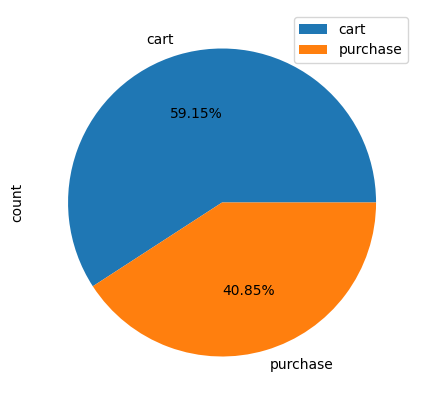

In [116]:
events = df.groupBy('event_type').count().toPandas()
events.plot(kind='pie', y='count', labels=events['event_type'], autopct='%1.2f%%', figsize=(5, 5))

In [117]:
## No. of different products
df.select(f.countDistinct("product_id")).show()

+--------------------------+
|count(DISTINCT product_id)|
+--------------------------+
|                     95137|
+--------------------------+



In [118]:
## No. of different users
df.select(f.countDistinct("user_id")).show()

+-----------------------+
|count(DISTINCT user_id)|
+-----------------------+
|                 807030|
+-----------------------+



In [119]:
## No. of distinct user sessions
df.select(f.countDistinct("user_session")).show()

+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                     1638658|
+----------------------------+



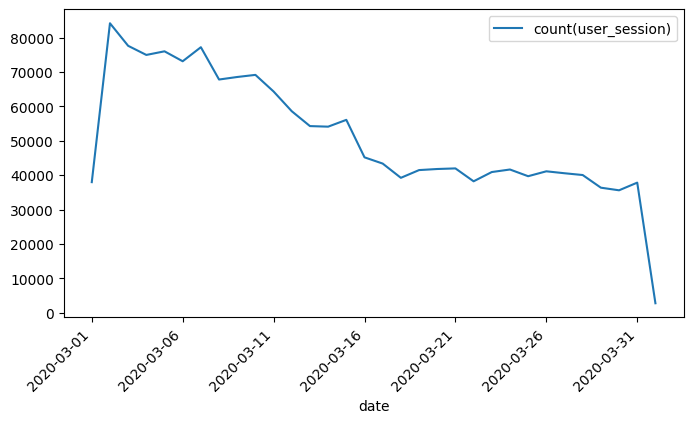

In [120]:
# Plot the daily number of sessions

df = df.withColumn('event_time', to_timestamp('event_time'))
df = df.withColumn('date', date_format("event_time", "yyyy-MM-dd"))

sessions = df.groupby('date').agg(countDistinct('user_session')).toPandas()
sessions.sort_values('date').plot(x='date', figsize=(8, 4))

# Adjust x-axis tick labels
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

In [121]:
# Print the number of interactions between users and products, sorted by carts

interactions = df.groupby(['user_id', 'product_id']).agg(sum(when(df['event_type'] == 'cart', 1)).alias('carts'),                                                         
                                                         sum(when(df['event_type'] == 'purchase', 1)).alias('purchases'))

interactions.sort('carts', ascending=False).show()

+---------+----------+-----+---------+
|  user_id|product_id|carts|purchases|
+---------+----------+-----+---------+
|551091662|   1002547|  560|        2|
|602076415|   1004838|  451|     null|
|615988914|  26300078|  430|     null|
|627374934|   1005115|  275|     null|
|518912191| 100044095|  240|        1|
|588636531|   1005160|  220|     null|
|594209912|  15901905|  218|     null|
|623570724|   1005160|  206|     null|
|590249793|   1004446|  198|     null|
|632638072| 100052236|  193|     null|
|624447410|   1005160|  183|     null|
|521691769|   1004836|  183|     null|
|549436946|   1004856|  170|     null|
|544627381|  41200012|  168|     null|
|570641148|   1004856|  158|        3|
|616210103| 100038146|  149|     null|
|628661587|  26016675|  145|     null|
|622653284| 100132689|  138|     null|
|624605470|   1004750|  136|     null|
|613869936|   1005160|  130|        3|
+---------+----------+-----+---------+
only showing top 20 rows



In [122]:
df.groupby('product_id').agg(f.collect_set('cat_0'))\
                        .filter(size(col('collect_set(cat_0)')) == 1).count()

95137

In [123]:
## No. of product categories
df.select(f.countDistinct("cat_0")).show()

+---------------------+
|count(DISTINCT cat_0)|
+---------------------+
|                   14|
+---------------------+



In [124]:
df.filter((col('brand') != 'NA') & (col('cat_0') == 'NA') & (col('cat_1') == 'NA') & (col('cat_2') == 'NA') & (col('cat_3') == 'NA')).count()

230185

In [125]:
df.filter((col('brand') == 'NA') & (col('cat_0') != 'NA')).count()

196063

### Data Preprocess

In [126]:
# Not run yet
def preprocess(df):
    
    # Change data types
    df = df.withColumn('event_time', to_timestamp('event_time'))
    df = df.withColumn('user_id', col('user_id').cast('integer'))
    df = df.withColumn('product_id', col('product_id').cast('integer'))

    # Discarding unwanted product categories
    df = df.filter(~col('cat_0').isin('construction', 'apparel', 'auto', 'medicine'))
    df = df.filter((col('brand') != 'NA') | (col('cat_0') != 'NA'))

    return df

df = preprocess(df)

In [127]:
# Filter rows where 'brand' is 'NA' and 'cat_0' is not 'NA'
R = df.filter((col('brand') == 'NA') & (col('cat_0') != 'NA'))

# Filter rows where both 'brand' and 'cat_0' are not 'NA'
S = df.filter((col('brand') != 'NA') & (col('cat_0') != 'NA'))

In [128]:
def count_matching_rows(R, distinct_values):
    count = 0
    for row in R.collect():
        if row['cat_0'] in distinct_values:
            count += 1
    return count

# Usage:
distinct_values = S.select(col('cat_0')).distinct().toPandas()['cat_0'].tolist()
matching_count = count_matching_rows(R, distinct_values)
print("Number of rows where R['cat_0'] matches distinct values:", matching_count)


Number of rows where R['cat_0'] matches distinct values: 119711


In [129]:
df.filter((col('brand') == 'NA') & (col('cat_0') != 'NA')).count()

119711

### Feature Engineering

In [130]:
# Partition dataframes for null and non-null values

# R is the dataframe where brand is unknown and product is known
R = df.filter((col('brand') == 'NA') & (col('cat_0') != 'NA'))

# S is the dataframe where brand is known and product is unknown
S = df.filter((col('brand') != 'NA') & (col('cat_0') == 'NA'))

# df_new is the dataframe where only non-null values of 'brand' and 'cat_0' are kept
df_new = df.filter((col('brand') != 'NA') & (col('cat_0') != 'NA'))
df_new = df_new.dropna(subset=['user_session'])

In [131]:
def add_category_code(df):
    # Create a new column 'category_code' by concatenating 'cat_0' and 'cat_1'
    df = df.withColumn('category_code', concat(col('cat_0'), lit(".") , col('cat_1')))
    return df

df_new = add_category_code(df_new)

In [132]:
def add_category_id(df):
    # Create a StringIndexer to generate category_id based on category_code
    indexer = StringIndexer(inputCol='category_code', outputCol='category_id', handleInvalid="keep")
    indexed_df = indexer.fit(df).transform(df)
    
    # Convert indexed values to integers
    indexed_df = indexed_df.withColumn('category_id', col('category_id').cast('integer'))
    
    return indexed_df

df_new = add_category_id(df_new)
df_new.show(5, truncate= False)

+-------------------+----------+----------+---------+------+---------+------------------------------------+------+-----------+-----------+------+-----+-------------------+-------+---------+----------+------+--------+-------+----------+----------------------+-----------+
|event_time         |event_type|product_id|brand    |price |user_id  |user_session                        |target|cat_0      |cat_1      |cat_2 |cat_3|timestamp          |ts_hour|ts_minute|ts_weekday|ts_day|ts_month|ts_year|date      |category_code         |category_id|
+-------------------+----------+----------+---------+------+---------+------------------------------------+------+-----------+-----------+------+-----+-------------------+-------+---------+----------+------+--------+-------+----------+----------------------+-----------+
|2020-03-01 05:30:59|cart      |6902464   |zlatek   |49.91 |531574188|48714293-b3f9-4946-8135-eb1ea05ead74|0     |electronics|telephone  |NA    |NA   |2020-03-01 05:30:59|0      |0       

#### Testing on a sample data only
Taking 10000 rows to check if the model is working or not

In [133]:
# df_new = df_new.limit(100000)
print(df_new.count())

861540


In [134]:
def product_features(df):

    # Calculate several metrics for products with the aggregate function
    df = df.groupby('product_id').agg(first('category_id').alias('category_id'),
                                      first('category_code').alias('category_code'),
                                      count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                      count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                      mean('price').alias('price'),
                                      min('event_time').alias('first_date'),
                                      max('event_time').alias('last_date'))
    
    # Calculate interaction rates

    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    return df

In [135]:
def category_features(df):
    
    # Calculate the average product price for each category
    products = df.dropDuplicates(subset=['product_id'])
    products = products.groupby('category_id').agg(avg('price').alias('average_price'))

    # Calculate several metrics for categories with the aggregate function
    df = df.groupby('category_id').agg(first('category_code').alias('category_code'),
                                       countDistinct('product_id').alias('number_of_products'),
                                       count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                       count(when(df['event_type'] == 'purchase', True)).alias('purchases'))
    
    # Calculate interaction rates
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    df = df.join(products, on='category_id')
    
    return df

In [136]:
# Calculate smoothed rates for categories with small sample size using means of all products to combat overfitting
    
def category_smoothener(categories, mean, attr, rate, min_sample_size=1000):
    
    # Weighted average of category value and overall mean
    categories = categories.withColumn(rate, when(categories[attr] < min_sample_size, ((categories[rate] * categories[attr]) + (mean * (min_sample_size - categories[attr]))) / min_sample_size).otherwise(categories[rate]))
    
    return categories

In [137]:
# Calculate smoothed rates for products with small sample size using category means to combat overfitting
    
def product_smoothener(products, categories, attr, rate, min_sample_size=1000):
    
    category_rate = rate + '_cat'
    categories = categories.withColumnRenamed(rate, category_rate)
    products = products.join(categories['category_id', category_rate], on='category_id')
    
    # Weighted average of product value and category value
    products = products.withColumn(rate, when(products[attr] < min_sample_size, ((products[rate] * products[attr]) + (products[category_rate] * (min_sample_size - products[attr]))) / min_sample_size).otherwise(products[rate]))
    
    products = products.drop(category_rate)
    return products

In [138]:
# Calculate the price of each product relative to its category using the formula: (price - median) / IQR

def calculate_relative_price(products):
    
    categories = products.groupby('category_id').agg(percentile_approx('price', 0.25, 1000).alias('Q1'),
                                                     percentile_approx('price', 0.5, 1000).alias('median'),
                                                     percentile_approx('price', 0.75, 1000).alias('Q3'))
    # Interquartile range
    categories = categories.withColumn('IQR', col('Q3') - col('Q1'))
    categories = categories.withColumn('IQR', when(col('IQR') < 1, 1).otherwise(col('IQR')))
    
    # Calculate relative price
    products = products.join(categories, on='category_id')
    products = products.withColumn('relative_price', (col('price') - col('median')) / col('IQR'))
    
    # In order to avoid extreme values, set the max possible value to 5
    products = products.withColumn('relative_price', when(col('relative_price') > 5, 5).otherwise(col('relative_price')))

    # Set the min possible value to -5
    products = products.withColumn('relative_price', when(col('relative_price') < -5, -5).otherwise(col('relative_price')))

    products = products.select('product_id', 'relative_price')
    return products

In [139]:
# Extract product and category features

products = product_features(df_new)
categories = category_features(df_new)

In [140]:
# Calculate relative prices and append it to the main dataframe and product features

relative_prices = calculate_relative_price(products)

df_new = df_new.join(relative_prices, on='product_id')
products = products.join(relative_prices, on='product_id')

In [141]:
# Calculate the average interaction rates for all products to smooth category features with low interaction

avg_purchase_per_cart = events[events['event_type'] == 'purchase']['count'].values[0] / events[events['event_type'] == 'cart']['count'].values[0]

categories = category_smoothener(categories, avg_purchase_per_cart, 'carts', 'purchase_per_cart', 200)

In [142]:
# Smooth product features with low interaction using corresponding category features

products = product_smoothener(products, categories, 'carts', 'purchase_per_cart', 100)

In [143]:
def user_features(df):

    # Calculate several metrics for users with the aggregate function
    df = df.groupby('user_id').agg(count(when(df['event_type'] == 'cart', True)).alias('carts'),
                                   count(when(df['event_type'] == 'purchase', True)).alias('purchases'),
                                   countDistinct(when(df['event_type'] == 'cart', col('product_id'))).alias('distinct_products_carted'),
                                   countDistinct(when(df['event_type'] == 'purchase', col('product_id'))).alias('distinct_products_purchased'),
                                   mean(when(df['event_type'] == 'purchase', col('price'))).alias('average_price_purchased'),
                                   mean(when(df['event_type'] == 'purchase', col('relative_price'))).alias('avg_relative_price_purchased'),
                                   min('event_time').alias('first_date'),
                                   max('event_time').alias('last_date'))
    
    # Calculate interaction rates
    df = df.withColumn('purchase_per_cart', when(df['carts'] == 0, df['purchases']).otherwise(df['purchases'] / df['carts']))
    
    return df

In [144]:
# Extract user features

users = user_features(df_new)

In [145]:
# Top 50 products in terms of purchases

# products.sort('purchases', ascending=False).toPandas().head(50)
products.printSchema()

root
 |-- category_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- carts: long (nullable = false)
 |-- purchases: long (nullable = false)
 |-- price: double (nullable = true)
 |-- first_date: timestamp (nullable = true)
 |-- last_date: timestamp (nullable = true)
 |-- purchase_per_cart: double (nullable = true)
 |-- relative_price: double (nullable = true)



In [146]:
# Convert timestamp columns to datetime
products = products.withColumn('first_date', col('first_date').cast('timestamp'))
products = products.withColumn('last_date', col('last_date').cast('timestamp'))

# Sort the DataFrame by 'purchases' column in descending order
top_50_products = products.orderBy(col('purchases').desc()).limit(50)

In [147]:
top_50_products.show()

+-----------+----------+--------------------+-----+---------+------------------+-------------------+-------------------+------------------+--------------------+
|category_id|product_id|       category_code|carts|purchases|             price|         first_date|          last_date| purchase_per_cart|      relative_price|
+-----------+----------+--------------------+-----+---------+------------------+-------------------+-------------------+------------------+--------------------+
|          1|   4804056|       sport.bicycle|24572|    18855|162.28739286619347|2020-03-01 06:28:45|2020-04-01 05:08:25|0.7673368061207879|  1.8131856453041117|
|          1|   4804055|       sport.bicycle| 6868|     5391|197.36150093808763|2020-03-01 05:47:07|2020-04-01 05:16:14| 0.784944670937682|   2.327393357837379|
|          1|   4804718|       sport.bicycle| 4550|     3643| 309.3075149517817|2020-03-01 07:47:37|2020-04-01 02:27:37|0.8006593406593406|   3.968589868813688|
|          1|   4804660|       spo

### Collaborative filtering

In [148]:
# Get the timestamp of the most recent event in the df
last_date = df_new.agg(max('event_time')).collect()[0][0]
df_new = df_new.withColumn('last_date', lit(last_date))

# Calculate the recency of each event in terms of days
df_new = df_new.withColumn('recency', (col('last_date').cast('double') - col('event_time').cast('double')) / 86400)
df_new = df_new.drop('last_date')

# Half-life decay function, the value of an event is halved after 20 days
df_new = df_new.withColumn('recency_coef', expr('exp(ln(0.5)*recency/20)'))

In [149]:
# Find the number of carts and purchases for each user-product pair
interactions = df_new.groupby(['user_id', 'product_id']).agg(sum(when(df_new['event_type'] == 'cart', 1) * df_new['recency_coef']).alias('carts'),
                                                         sum(when(df_new['event_type'] == 'purchase', 1) * df_new['recency_coef']).alias('purchases'))
interactions = interactions.na.fill(0)

In [150]:
def calculate_interaction_matrix(df, cart_weight=0.4, purchase_weight=1.0):
 
    # Create a new column with the weighted interaction value
    df = df.withColumn('interaction', cart_weight * col('carts') + purchase_weight * col('purchases'))
    
    # Use log10 value for views, carts and purchases
    df = df.withColumn('interaction', log10(col('interaction') + 1))
    
    # Set the max possible value to 100 (log100 = 2)
    df = df.withColumn('interaction', when(col('interaction') > 2, 2).otherwise(col('interaction')))

    return df

In [151]:
interaction_matrix = calculate_interaction_matrix(interactions)

In [152]:
#  User-product pairs with the highest interaction scores

interaction_matrix.sort('interaction', ascending=False).show()

+---------+----------+------------------+-------------------+------------------+
|  user_id|product_id|             carts|          purchases|       interaction|
+---------+----------+------------------+-------------------+------------------+
|615988914|  26300078|178.05212198478904|                0.0|1.8586625882772885|
|632638072| 100052236| 154.6214043090325|                0.0|1.7982953433959528|
|518912191| 100044095|111.24174743850766|0.47001318976063694|1.6624434413271754|
|598224683|   1801849|13.424844233738865|  37.33082417567878| 1.640489008427953|
|633302060|   3601405|100.98210731236564|                0.0|1.6169252554468156|
|523654377|   3700779| 99.41955424644613|                0.0|1.6103175069007518|
|548750897|   1801898| 4.049153608168345|  37.36964203810354|1.6019438398216557|
|600978657| 100120437| 90.13463110082145|                0.0| 1.568833367689136|
|626214265| 100006963|25.858046831064506| 22.883837154193643|1.5343695439761775|
|549264404|   1307545| 70.36

In [153]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

def cross_validate_als(interaction_matrix):
    
    # Define the ALS model
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction', 
              nonnegative=True, coldStartStrategy='drop', implicitPrefs=True)

    # Define the parameter grid for hyperparameter tuning
    param_grid = ParamGridBuilder() \
        .addGrid(als.rank, [5, 10, 15, 20]).addGrid(als.regParam, [0.005, 0.01, 0.05, 0.1]) \
        .addGrid(als.alpha, [0, 1.0, 5.0]) \
        .build()
        
    # Define the evaluator for computing the evaluation metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')

    # Define the cross-validator for performing 5-fold cross-validation
    cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5, collectSubModels=False)

    # Define the pipeline for fitting the model and evaluating it
    pipeline = Pipeline(stages=[cv])

    # Fit the pipeline on the data and evaluate the model
    model = pipeline.fit(interaction_matrix)
    
    return model

In [154]:
# # starting the monitoring
# tracemalloc.start()
 
# # function call
# model = cross_validate_als(interaction_matrix)

# # Model with the lowest RMSE value 
# bestModel = model.stages[0].bestModel

# # Make predictions
# predictions = bestModel.transform(interaction_matrix)
 
# # displaying the memory
# print(tracemalloc.get_traced_memory())
 
# # stopping the library
# tracemalloc.stop()

In [155]:
# # Calculate RMSE and MAE metrics
# evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
# rmse = evaluator.setMetricName('rmse').evaluate(predictions)
# mae = evaluator.setMetricName('mae').evaluate(predictions)
# print(' rmse:' + str(rmse) + ' mae:' + str(mae))

# # Print the parameters of the model with the lowest RMSE value
# regParam = bestModel._java_obj.parent().getRegParam()
# rank = bestModel._java_obj.parent().getRank()
# alpha = bestModel._java_obj.parent().getAlpha()
# print('rank:' + str(rank) + ' regParam:' + str(regParam) + ' alpha:' + str(alpha))

In [156]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

def simple_als(interaction_matrix):
    
    # Train-test split
    (train, test) = interaction_matrix.randomSplit([0.8, 0.2])
    
    # Initialize the model with the optimized parameters
    als = ALS(userCol='user_id', itemCol='product_id', ratingCol='interaction', 
              alpha=5.0, regParam=0.1, rank=20, implicitPrefs=True, 
              nonnegative=True, coldStartStrategy='drop')

    # Fit the ALS model on the ratings data
    model = als.fit(train)
    
    # Make predictions
    predictions = model.transform(test)
    
    # Calculate the RMSE and MAE metrics
    evaluator = RegressionEvaluator(metricName='rmse', labelCol='interaction', predictionCol='prediction')
    rmse = evaluator.evaluate(predictions)
    mae = evaluator.setMetricName('mae').evaluate(predictions)
    print('test rmse:' + str(rmse) + ' mae:' + str(mae))
    
    return model

In [157]:
als_model = simple_als(interaction_matrix)

test rmse:0.22298220894667203 mae:0.18658479554098714


### Recommend Products for Users

In [158]:
# 3 random users
user_subset = [633770714, 598224683, 518089189]

# Recommend top 500 products for the users
recommendations = sc.createDataFrame([(user, 0) for user in user_subset], ['user_id', 'product_id'])
recommendations = als_model.recommendForUserSubset(recommendations, 500)

In [159]:
recommendations.show()

Py4JJavaError: An error occurred while calling o2672.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 2107.0 failed 1 times, most recent failure: Lost task 1.0 in stage 2107.0 (TID 3515) (DESKTOP-47DU1LS executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:601)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:583)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:772)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:398)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:757)
	... 22 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:601)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:583)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:772)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:398)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:757)
	... 22 more


In [53]:
# Select user 598224683
recs_for_user_1 = sc.createDataFrame(recommendations.collect()[1][1])

Py4JJavaError: An error occurred while calling o906.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 701.0 failed 1 times, most recent failure: Lost task 0.0 in stage 701.0 (TID 1164) (DESKTOP-47DU1LS executor driver): org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:601)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:583)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:772)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:386)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:757)
	... 22 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2785)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2721)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2720)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2720)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1206)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1206)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2984)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2923)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2912)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: Python worker exited unexpectedly (crashed)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:601)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator$$anonfun$1.applyOrElse(PythonRunner.scala:583)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFunction.scala:38)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:772)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:749)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:514)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:491)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage2.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anon$1.hasNext(WholeStageCodegenExec.scala:760)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:101)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:139)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:554)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1529)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:557)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1144)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:642)
	at java.base/java.lang.Thread.run(Thread.java:1623)
Caused by: java.io.EOFException
	at java.base/java.io.DataInputStream.readInt(DataInputStream.java:386)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:757)
	... 22 more


In [55]:
# Products with the highest number of interactions for the user

interactions.filter(col('user_id') == 598224683).sort('purchases', ascending=False).show()

+---------+----------+------------------+-------------------+
|  user_id|product_id|             carts|          purchases|
+---------+----------+------------------+-------------------+
|598224683|   1801849|13.424844233738863|  37.33082417567878|
|598224683|   3601603|6.2620832926326235|    22.264547887824|
|598224683|   2702277|  9.55221687363865| 18.053328823812244|
|598224683|   1801881| 6.390755930878592| 16.910094820955166|
|598224683| 100090024|0.8477618219750345| 12.433686143827385|
|598224683|   2702331| 7.777080826520921|  11.77571379897072|
|598224683|   1801690|2.2708173537544427| 10.887466858444705|
|598224683|   1801854| 4.998308034847588|   8.88716004939163|
|598224683|   2702347|1.4074105329640159|  4.572105823580895|
|598224683|   3601522|               0.0|   3.53890490486224|
|598224683|   3601448|               0.0| 1.5693465682843657|
|598224683|   1802009|               0.0| 1.2396221781012216|
|598224683|   3601605|               0.0| 0.9796906306653123|
|5982246

In [56]:
def calculate_recommendation_scores_for_user(user_id, recs, products, users, coef_als_score=0.8, coef_conversion_rate=0.1, coef_spending_habit=0.1, coef_spending_booster=0.05):
   
    recs = recs.join(products['product_id', 'purchase_per_view', 'relative_price'], on='product_id')
    
    user_avg_relative_price = users.filter(col('user_id') == user_id)['user_id', 'avg_relative_price_purchased'].collect()[0][1]

    
    # Scale CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') / 2)
    
    # Scale purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') / 0.075)
    
    # Scale relative price value, ranges from -5 to 5
    recs = recs.withColumn('relative_price', (col('relative_price') + 5) / 10)
    
    # Scale users average relative price value, ranges from -1 to 1
    user_avg_relative_price = (user_avg_relative_price + 1) / 2
    
    
    # Calculate the recommendation scores
    recs = recs.withColumn('recommendation_score', ((recs['rating'] * coef_als_score) + (recs['purchase_per_view'] * coef_conversion_rate) - abs(user_avg_relative_price + coef_spending_booster - recs['relative_price']) * coef_spending_habit) / (coef_als_score + coef_conversion_rate + coef_spending_habit)) 

    
    # Scale back CF rating score, ranges from 0 to 2
    recs = recs.withColumn('rating', col('rating') * 2)

    # Scale back purchase_per_view rate, ranges from 0 to 0.075
    recs = recs.withColumn('purchase_per_view', col('purchase_per_view') * 0.075)
    
    # Scale back relative price value, ranges from -1 to 1
    recs = recs.withColumn('relative_price', col('relative_price') * 2 - 1)

    # Scale back average relative price value, ranges from -5 to 5
    user_avg_relative_price = user_avg_relative_price * 10 - 5
    
    return recs

In [57]:
recs_user = calculate_recommendation_scores_for_user(598224683, recs_for_user_1, products, users)

NameError: name 'recs_for_user_1' is not defined

In [ ]:
# Products with the highest recommendation scores

recs_user.sort('recommendation_score', ascending=False).show()

In [ ]:
# Filter non-interacted products in recommendations using left-anti join
non_interacted_products = recs_user.join(interactions.filter(col('user_id') == 564068124), on='product_id', how='leftanti')

# Non-interacted products with the highest recommendation scores
non_interacted_products.sort('recommendation_score', ascending=False).show()

### Recommend Products for Products

In [ ]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import SQLTransformer

# Get the product factors from the ALS model
product_vectors = best_model.itemFactors
product_vectors = product_vectors.rdd.map(lambda row: (row[0], Vectors.dense(row[1])))
product_vectors = product_vectors.toDF(['product_id', 'features'])

# Use VectorAssembler to convert the features column into a dense vector column
assembler = VectorAssembler(inputCols=['features'], outputCol='vector')
product_vectors = assembler.transform(product_vectors)

# Normalize the vectors
normalizer = Normalizer(inputCol='vector', outputCol='norm_vector')
product_vectors = normalizer.transform(product_vectors)

# Get the normalized vector representation of the selected product
product_vector = product_vectors.where(col('product_id') == 5100067).select('norm_vector').collect()[0][0]
product_vector